# Project 1: Viral vs. Human Prediction

In [6]:
import warnings
warnings.simplefilter(action='ignore')
from Bio import SeqIO
import numpy as np
from tqdm import tqdm
import seaborn as sns
from matplotlib import pyplot as plt
import keras.backend as K
from keras import models
import os
import pickle
from keras.layers import *
from keras.models import Sequential, load_model, Model
from keras.utils import multi_gpu_model 
import matplotlib.pylab as plt
from skimage.transform import resize
from keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold
from IPython.display import SVG
from tqdm import tnrange

The encodings are as follows:
1. A = [1, 0, 0, 0, 0]
2. C = [0, 1, 0, 0, 0]
3. G = [0, 0, 1, 0, 0]
4. N = [0, 0, 0, 1, 0]
5. T = [0, 0, 0, 0, 1]

### load data set

In [2]:
root_dir = '/home/ecvol/data/viral/'

In [3]:
X_test = np.load(root_dir + 'integ_test_set.npy')
Y_test = np.load(root_dir + 'integ_test_set_label.npy')
X_train = np.load(root_dir + 'integ_train_set.npy')
Y_train = np.load(root_dir + 'integ_train_set_label.npy')
print("X_train shape: ", X_train.shape, "Y_train shape: ", Y_train.shape, "X_test shape", X_test.shape)

X_train shape:  (1000000, 150, 5, 1) Y_train shape:  (1000000, 150) X_test shape (1000000, 150, 5, 1)


674000 reads from 337 hpv references
1M reads from chr1

In [4]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1,2,3,4,5,6,7"

In [4]:
earlystopper = EarlyStopping(monitor='loss', patience=7, verbose=1)
for num_filters in [32]:
    for kmer_size in [10]:
        inputs = Input(shape=(150,5,1))
        
        x1 = Conv2D(num_filters, kernel_size=(kmer_size,5), activation='relu', dilation_rate = (1,1), padding='same')(inputs)
        x1 = BatchNormalization()(x1)
        x1 = concatenate([inputs, x1])
        
        x2 = Conv2D(num_filters, kernel_size=(kmer_size,5), activation='relu', dilation_rate = (1,1), padding='same')(x1)
        x2 = BatchNormalization()(x2)
        x2 = concatenate([inputs, x1, x2])
        
        x3 = Conv2D(num_filters, kernel_size=(kmer_size,5), activation='relu', dilation_rate = (2,1), padding='same')(x2)
        x3 = BatchNormalization()(x3)
        x3 = concatenate([inputs, x1, x2, x3])
        
        x4 = Conv2D(num_filters, kernel_size=(kmer_size,5), activation='relu', dilation_rate = (4,1), padding='same')(x3)
        x4 = BatchNormalization()(x4)
        x4 = concatenate([inputs, x1, x2, x3, x4])
        
        x5 = Conv2D(num_filters, kernel_size=(kmer_size,5), activation='relu', dilation_rate = (8,1), padding='same')(x4)
        x5 = BatchNormalization()(x5)
        x5 = concatenate([inputs, x1, x2, x3, x4, x5])
        
        x6 = Conv2D(num_filters, kernel_size=(kmer_size,5), activation='relu', dilation_rate = (1,1), padding='same')(x5)
        x6 = BatchNormalization()(x6)
        x6 = concatenate([inputs, x1, x2, x3, x4, x5, x6])
        
        x7 = Conv2D(num_filters, kernel_size=(1,5), activation='relu', dilation_rate = (1,1), padding='same')(x6)
        x7 = BatchNormalization()(x7)
        x = Dropout(0.3)(x7)
        x = Flatten()(x)
        outputs = Dense(150, activation='sigmoid')(x)
        model = Model(inputs=[inputs], outputs=[outputs])
        print(model.summary())
        model = multi_gpu_model(model, gpus=8)
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        history = model.fit(X_train, Y_train, epochs=20, validation_split=0.25, 
                  batch_size=2000, verbose=1, callbacks=[earlystopper])
        #hist_name = '/home/ecvol/viral/history/' + str(kmer_size) + '_' + str(num_filters) 
        hist_name = '/home/ecvol/viral/history/integ'
        with open(hist_name, 'wb') as file_pi:
            pickle.dump(history.history, file_pi)
       # K.clear_session()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 5, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 150, 5, 32)   1632        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 150, 5, 32)   128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
concatenate_1 (Concat

Train on 750000 samples, validate on 250000 samples
Epoch 1/20
750000/750000 [==============================] - 256s 341us/step - loss: 0.3279 - acc: 0.8504 - val_loss: 0.2115 - val_acc: 0.9106
Epoch 2/20
750000/750000 [==============================] - 230s 307us/step - loss: 0.1741 - acc: 0.9271 - val_loss: 0.1784 - val_acc: 0.9246
Epoch 3/20
750000/750000 [==============================] - 229s 305us/step - loss: 0.1339 - acc: 0.9440 - val_loss: 0.1427 - val_acc: 0.9401
Epoch 4/20
750000/750000 [==============================] - 228s 304us/step - loss: 0.1133 - acc: 0.9524 - val_loss: 0.1267 - val_acc: 0.9473
Epoch 5/20
750000/750000 [==============================] - 225s 300us/step - loss: 0.1006 - acc: 0.9577 - val_loss: 0.1302 - val_acc: 0.9457
Epoch 6/20
750000/750000 [==============================] - 226s 302us/step - loss: 0.0919 - acc: 0.9613 - val_loss: 0.1164 - val_acc: 0.9517
Epoch 7/20
750000/750000 [==============================] - 227s 302us/step - loss: 0.0850 - acc

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


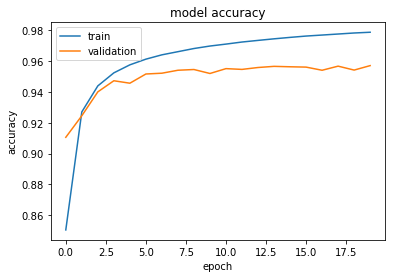

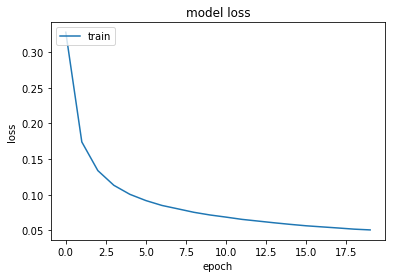

In [5]:
model.save("integ_viral_pred.h5")
print(history.history.keys())
# #  "Accuracy"

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [4]:
model = load_model("integ_viral_pred.h5")

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [5]:
predictions = model.predict(X_test, verbose=1)
Y_test = Y_test == 1
#print(Y_test[:10], Y_test.shape)

1000000/1000000 [==============================] - 1832s 2ms/step


In [10]:
r = 100
print('GT: ', Y_test[r])
print('predictions: ', predictions[r]>0.05)

GT:  [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False]
predictions:  [ True  True  True  True  True  True  True  True  True  True  True 

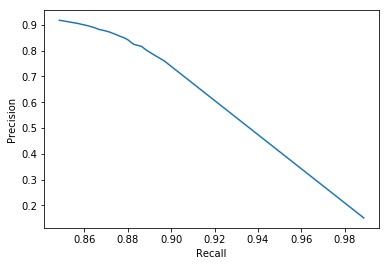

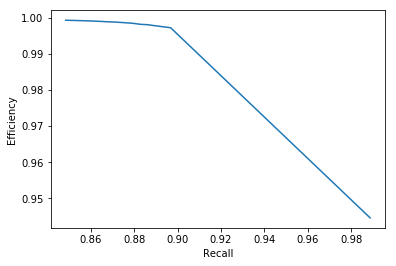

In [15]:
P = []
R = []
E = []
num_viral = 10000
num_hum = 1000000
for t in np.arange(0,1,0.05).tolist():
    temp = (predictions > t)
    TP = 0
    FP = 0
    for i,j in zip(temp, Y_test):
        if (i and j):
            TP += 1
        if (i and not j):
            FP += 1
    
    FN = num_viral - TP
    P.append(TP / (TP + FP))
    R.append(TP / (TP + FN))
    E.append(1 - (FP/(num_hum)))
sns.lineplot(R, P)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()
sns.lineplot(R, E)
plt.xlabel('Recall')
plt.ylabel('Efficiency')
plt.show()